# ResNet Classification and Object Detection
## COMP9517 23T2 Group Project


### Load the required Libraries

In [120]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add,MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from keras.callbacks import History
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import os
import json
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
from keras.utils import normalize

# Data Description


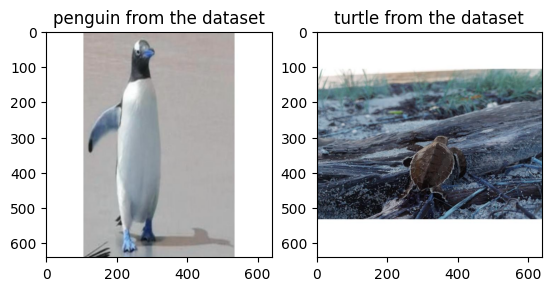

In the training dataset, there are 250 images of penguins and 250 images of turtles


In [23]:
def load_data():
    train_dir = './train/train'
    train_ann = 'train_annotations'
    
    train_images = []
    annotations = []
    with open(train_ann, 'r') as f:
        train_annotations = json.load(f)
    
    for annotation in train_annotations:
        image_path = os.path.join(train_dir, f"image_id_{str(annotation['image_id']).zfill(3)}.jpg")
        image = cv2.imread(image_path)
        train_images.append(image)
        annotations.append(annotation['category_id'])
    
    
    f, axarr = plt.subplots(1,2)
    axarr[0].set_title("penguin from the dataset")
    axarr[0].imshow(train_images[0])
    axarr[1].set_title("turtle from the dataset")
    axarr[1].imshow(train_images[2])
    plt.show()
    
    
    num_peng = annotations.count(1)
    num_turt = annotations.count(2)
    print(f"In the training dataset, there are {num_peng} images of penguins and {num_turt} images of turtles", end="\n")

load_data()         

# Classification

### Loading and Preprocessing the Data.
Assuming that the the train, validation and annotation folders/files are in the same directory. <br>
Since there are only two classes of data, we convert the class_id's to 0 (for penguin) and 1 (for turtle) for binary classification.

In [75]:

def load_training_data():
    train_dir = './train/train'
    train_ann = 'train_annotations'

    with open(train_ann, 'r') as f:
        train_annotations = json.load(f)
    
    # Prepare the training data
    X_train = []
    y_train = []
    X_val = []
    y_val = []

    for annotation in train_annotations:
        image_path = os.path.join(train_dir, f"image_id_{str(annotation['image_id']).zfill(3)}.jpg")
        image = cv2.imread(image_path)
        resized = cv2.resize(image, (160,160))
        X_train.append(resized)
        if (annotation['category_id'] == 1):
            y_train.append(0)
        else:
            y_train.append(1)

    # Split the data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)
    
    # Apply data augmentation for the training set
    X_train_augmented = []
    y_train_augmented = []
    for i in range(len(X_train)):
        augmented_images = apply_data_augmentation(X_train[i])
        for a in augmented_images:
            X_train_augmented.append(a)
            y_train_augmented.append(y_train[i])

    X_train = X_train_augmented
    y_train = y_train_augmented
        
    
    # Convert lists to arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_val = np.array(X_val)
    y_val = np.array(y_val)


    return (X_train, X_val, y_train, y_val)


In [65]:
def apply_data_augmentation(image):
    augmented_images = [image]
    rows, cols = image.shape[:2]

    #rotate
    angle = np.random.randint(-30, 30)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    augmented_images.append(cv2.warpAffine(image, M, (cols, rows)))

    # translation
    tx, ty = np.random.randint(-50, 50, 2)
    M = np.array([[1, 0, tx], [0, 1, ty]], dtype=np.float32)
    augmented_images.append(cv2.warpAffine(image, M, (cols, rows)))

    # flip
    augmented_images.append(cv2.flip(image, 1))

    #zoom
    zoom_factor = np.random.uniform(1.0, 1.5)
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 0, zoom_factor)
    augmented_images.append(cv2.warpAffine(image, M, (cols, rows)))

    return augmented_images

## ResNet50 Implementation for Binary Classification

The core architecture of the ResNet was made from scratch referencing multiple online resources.
The output layer and parameters were arrived at after multiple rounds of training.


In [70]:
# Define the Residual Block
def residual_block(x, filters, strides=(1, 1), use_projection=False):
    shortcut = x

    # Projection shortcut when strides > 1 or input and output channels differ
    if use_projection:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # First Convolutional layer
    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Convolutional layer
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    # Add the shortcut (residual connection)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# Build a simplified ResNet-50
def build_resnet50(input_shape):
    inputs = Input(shape=input_shape)

    # Initial Convolutional layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, strides=(2, 2), use_projection=True)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, strides=(2, 2), use_projection=True)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, strides=(2, 2), use_projection=True)
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    # Global Average Pooling and Dense layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, output)
    return model

In [71]:
def load_test_data():
# load test data
    valid_dir = './valid/valid'
    valid_ann = 'valid_annotations'

    with open(valid_ann, 'r') as f:
        valid_annotations = json.load(f)

    # Prepare the training data
    X_test = []
    y_test = []

    for annotation in valid_annotations:
        image_path = os.path.join(valid_dir, f"image_id_{str(annotation['image_id']).zfill(3)}.jpg")
        image = cv2.imread(image_path)
        resized = cv2.resize(image, (160,160))
        X_test.append(resized)

        if (annotation['category_id'] == 1):
            y_test.append(0)
        else:
            y_test.append(1)
    
    # Convert lists to arrays
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    print(f"shape of training data is {X_test.shape}" )
    print(f"shape of training annotations is {y_test.shape}")
    
    return(X_test, y_test)



## Train the model

In [76]:
# Load the data to train the model
X_train, X_val, y_train, y_val = load_training_data()
print(X_train.shape)
print(y_train.shape)

(2250, 160, 160, 3)
(2250,)


In [73]:

# Define the learning rate scheduler function
def exponential_decay(epoch, initial_lr, decay_rate=0.96, epochs_decay=5):
    return initial_lr * tf.math.pow(decay_rate, epoch / epochs_decay)


Epoch 1/40


2023-08-01 14:20:09.519207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 0.9870 - accuracy: 0.6956

2023-08-01 14:20:27.025850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 20s 408ms/step - loss: 0.9870 - accuracy: 0.6956 - val_loss: 532357.3750 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
36/36 [==============================] - 12s 326ms/step - loss: 0.5047 - accuracy: 0.7618 - val_loss: 3210.8843 - val_accuracy: 0.5000 - lr: 9.9187e-04
Epoch 3/40
36/36 [==============================] - 11s 316ms/step - loss: 0.4146 - accuracy: 0.8204 - val_loss: 78.0979 - val_accuracy: 0.5000 - lr: 9.8380e-04
Epoch 4/40
36/36 [==============================] - 12s 330ms/step - loss: 0.3887 - accuracy: 0.8333 - val_loss: 8.9006 - val_accuracy: 0.5000 - lr: 9.7580e-04
Epoch 5/40
36/36 [==============================] - 12s 322ms/step - loss: 0.3506 - accuracy: 0.8591 - val_loss: 1.3233 - val_accuracy: 0.6200 - lr: 9.6787e-04
Epoch 6/40
36/36 [==============================] - 12s 328ms/step - loss: 0.3205 - accuracy: 0.8693 - val_loss: 0.9346 - val_accuracy: 0.6800 - lr: 9.6000e-04
Epoch 7/40
36/36 [============================

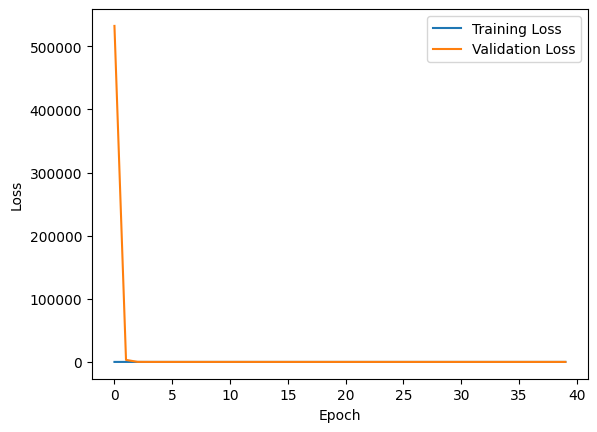

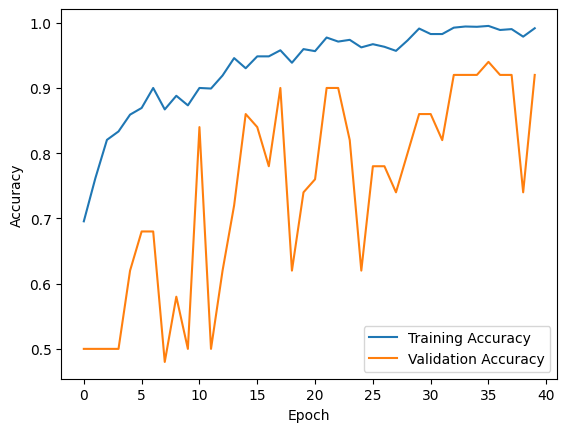

In [77]:


target_size = (160,160)

input_shape = target_size + (3,)
num_classes = 2

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))


model = build_resnet50(input_shape)

# Compile the model with an initial learning rate
initial_learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='binary_crossentropy', metrics=['accuracy'])


# Set up the callback for learning rate scheduling and metrics history
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: exponential_decay(epoch, initial_learning_rate))
history = History()

batch_size = 64
epochs = 40

training_history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[lr_scheduler, history])


train_loss = training_history.history['loss']
train_accuracy = training_history.history['accuracy']
val_loss = training_history.history['val_loss']
val_accuracy = training_history.history['val_accuracy']

plt.figure()
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure()
plt.plot(range(epochs), train_accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



## Evaluate the Model

In [97]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d_216 (Conv2D)         (None, 80, 80, 64)           9472      ['input_7[0][0]']             
                                                                                                  
 batch_normalization_216 (B  (None, 80, 80, 64)           256       ['conv2d_216[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_198 (Activation  (None, 80, 80, 64)           0         ['batch_normalization_21

In [126]:
# load validation data 
X_test, y_test = load_test_data()
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')
y_pred = model.predict(X_test) 




shape of training data is (72, 160, 160, 3)
shape of training annotations is (72,)
3/3 [==============================] - 2s 161ms/step - loss: 0.4488 - accuracy: 0.8194
Validation Loss: 0.4488, Validation Accuracy: 0.8194
3/3 [==============================] - 1s 156ms/step


In [125]:

predictions = []
for pred in y_pred:
    if (pred > 0.5):
        predictions.append(1)
    else :
        predictions.append(0)

cm = confusion_matrix(y_test, predictions)
precision_per_class = np.diagonal(cm) / np.sum(cm, axis=0)
print("Precision per class:", precision_per_class)
print(cm)
    

print(f"preds = {len(predictions)} and actual = {len(y_test)}",end="\n")
accuracy = np.mean(y_test == predictions)
print(f"Validation Accuracy: {accuracy:.4f}")
precision = precision_score(y_test, predictions, average='binary')
recall = recall_score(y_test, predictions, average='binary')
f1 = f1_score(y_test, predictions, average='binary') 

print (precision, recall, f1)


Precision per class: [0.81081081 0.82857143]
[[30  6]
 [ 7 29]]
preds = 72 and actual = 72
Validation Accuracy: 0.8194
0.8285714285714286 0.8055555555555556 0.8169014084507044


Example Classification

1/1 [==============================] - 0s 292ms/step


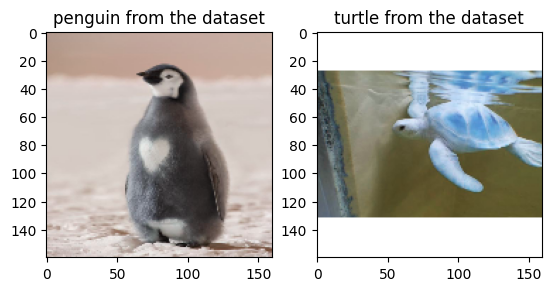

If the prediction value is closer to zero, then the prediction is a penguin
If the prediction value is closer to one, then the prediction is a turtle
The prediction of the first image is penguin, with the actual value of 0.0001
The prediction of the first image is turtle, with the actual value of 0.9778


In [127]:
test_images = X_test[:2]
predictions = model.predict(test_images)
f, axarr = plt.subplots(1,2)
axarr[0].set_title("penguin from the dataset")
axarr[0].imshow(test_images[0])
axarr[1].set_title("turtle from the dataset")
axarr[1].imshow(test_images[1])
plt.show()

print("If the prediction value is closer to zero, then the prediction is a penguin")
print("If the prediction value is closer to one, then the prediction is a turtle")

for p in predictions:
    if (p < 0.5):
        print (f"The prediction of the first image is penguin, with the actual value of {p[0]:.4f}")
    elif (p >= 0.5):
        print (f"The prediction of the first image is turtle, with the actual value of {p[0]:.4f}")
        
    


# print(prediction)

In [ ]:
# Save the model weights for later use
model.save('model_weights.h5')
